# Entre o Porto e a Cidade: Uma Investigação de Ciência de Dados sobre a Mobilidade na Travessia Santos-Guarujá em Tempos de Pandemia
## Um estudo comparativo usando dados de 2019 a 2025

**Resumo:**
A travessia de balsas Santos-Guarujá é um dos principais gargalos de mobilidade do litoral paulista. Este trabalho propõe uma abordagem de Ciência de Dados para investigar os determinantes desse fluxo entre 2019 e 2025, cruzando dados de transporte público com indicadores econômicos de comércio exterior (importações).
>
> A metodologia consistiu na coleta automatizada e tratamento de dados, seguida de análise exploratória e modelagem utilizando **XGBoost** (para seleção de atributos) e **Regressão Estrutural Bayesiana** (para inferência de incerteza).
>
> Os resultados demonstraram que, ao contrário do esperado, a correlação entre a atividade econômica do porto e o fluxo da balsa é fraca, sugerindo que a infraestrutura atende a uma demanda urbana saturada que não responde linearmente ao crescimento econômico. O estudo identificou ainda que o choque da pandemia gerou uma retração estrutural da qual o sistema não se recuperou totalmente, apresentando uma leve tendência de queda no longo prazo. O trabalho conclui discutindo os desafios de modelar sistemas reais sujeitos a alta volatilidade e restrições físicas de capacidade.

In [ ]:
!pip install pymc arviz requests seaborn pandas scikit-learn matplotlib -q

import requests
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from google.colab import drive

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 7)
warnings.filterwarnings('ignore')

## 1. Coleta e Preparação dos Dados

Para realizar este estudo, cruzamos duas fontes de dados públicos:

1.  **Movimentação das Travessias:** Dados mensais da **Secretaria de Meio Ambiente, Infraestrutura e Logística (SEMIL)**, [disponíveis](https://dadosabertos.sp.gov.br/dataset/volume-trav-lit) no Portal de Dados Abertos de SP. A métrica "Volume Total" agrega veículos, pedestres e ciclistas, mas não contabiliza passageiros no interior dos veículos.
2.  **Dados Econômicos:** Valores de importação (FOB) para Santos e Guarujá. Os [dados](https://repositorio.seade.gov.br/dataset/comercio-exterior) são originários do Sistema Integrado de Comércio Exterior (Siscomex/MDIC) e foram acessados através do repositório da **Fundação Seade**.

In [ ]:
print(">>> [1/5] Iniciando Coleta de Dados...")

# Download das Travessias (Dados Abertos SP)
urls = [
    "https://smastr16.blob.core.windows.net/dados-abertos/sites/30/2025/08/VOLUME-TRAVESSIAS-2019.xlsx",
    "https://smastr16.blob.core.windows.net/dados-abertos/sites/30/2025/08/VOLUME-TRAVESSIAS-2020.xlsx",
    "https://smastr16.blob.core.windows.net/dados-abertos/sites/30/2025/08/VOLUME-TRAVESSIAS-2021.xlsx",
    "https://smastr16.blob.core.windows.net/dados-abertos/sites/30/2025/08/VOLUME-TRAVESSIAS-2022.xlsx",
    "https://smastr16.blob.core.windows.net/dados-abertos/sites/30/2025/08/VOLUME-TRAVESSIAS-2023.xlsx",
    "https://smastr16.blob.core.windows.net/dados-abertos/sites/30/2025/08/VOLUME-TRAVESSIAS-2024.xlsx",
    "https://smastr16.blob.core.windows.net/dados-abertos/sites/30/2025/08/VOLUME-TRAVESSIAS-2025-jan-out.xlsx"
]

files_info = []
for url in urls:
    filename = url.split('/')[-1]
    match = re.search(r'\d{4}', filename) # Regex para extrair ano com segurança

    if match:
        year = int(match.group())
        if not os.path.exists(filename):
            try:
                r = requests.get(url)
                r.raise_for_status()
                with open(filename, 'wb') as f: f.write(r.content)
                print(f"✓ Baixado: {filename}")
            except: print(f"X Falha: {filename}")
        files_info.append((filename, year))

# Carregamento e Limpeza (Travessias)
meses_map = {'Jan':1, 'Fev':2, 'Mar':3, 'Abr':4, 'Mai':5, 'Jun':6,
             'Jul':7, 'Ago':8, 'Set':9, 'Out':10, 'Nov':11, 'Dez':12}

dfs = []
for filename, year in files_info:
    try:
        temp = pd.read_excel(filename, header=2)
        temp = temp[temp['Mês'].isin(meses_map.keys())].copy()
        temp['Ano'] = year
        dfs.append(temp)
    except: pass

df_raw = pd.concat(dfs, ignore_index=True)
df_raw['Mes_Num'] = df_raw['Mês'].map(meses_map)
df_raw['Data'] = pd.to_datetime(df_raw['Ano'].astype(str) + '-' + df_raw['Mes_Num'].astype(str) + '-01')
df_raw = df_raw.sort_values('Data')

# Carregamento da Economia (carregado manualmente. https://repositorio.seade.gov.br/dataset/comercio-exterior)
path_base = "./"

try:
    df_imp_raw = pd.read_csv(path_base + "Valor das importações por município do ESP.csv", sep=';', encoding='utf-8')
    df_conv = pd.read_csv(path_base + "conversao_uf_municipios.csv", sep=';', encoding='utf-8')

    # Filtro Santos e Guarujá
    codigos_litoral = df_conv[df_conv['Nome município (IBGE)'].isin(['Santos', 'Guarujá'])]['CO_MUN_COMEXTAT'].unique()
    df_imp_litoral = df_imp_raw[df_imp_raw['CO_MUN'].isin(codigos_litoral)].copy()

    # Agrupamento Mensal
    df_imp_agrupado = df_imp_litoral.groupby(['CO_ANO', 'CO_MES'])[['VALOR_FOB']].sum().reset_index()
    df_imp_agrupado['Data'] = pd.to_datetime(df_imp_agrupado['CO_ANO'].astype(str) + '-' +
                                            df_imp_agrupado['CO_MES'].astype(str) + '-01')
    print("✓ Dados Econômicos Processados.")
except Exception as e:
    print(f"X Erro nos dados econômicos (verifique o caminho do Drive): {e}")

>>> [1/5] Iniciando Coleta de Dados...
Mounted at /content/drive
✓ Dados Econômicos Processados.


## 2. Visão Geral do Sistema de Travessias

Antes de modelar, fizemos uma análise exploratória para entender como a travessia Santos-Guarujá se compara com as outras do estado.

Utilizamos um gráfico de dispersão relacionando o **Volume Médio** com a **Variação Sazonal** (o quanto o fluxo muda no verão). O objetivo é verificar se Santos/Guarujá é uma travessia turística (como Ilhabela) ou mais urbana/constante.


>>> [2/5] Gerando Análise Sistêmica (Tipologia)...


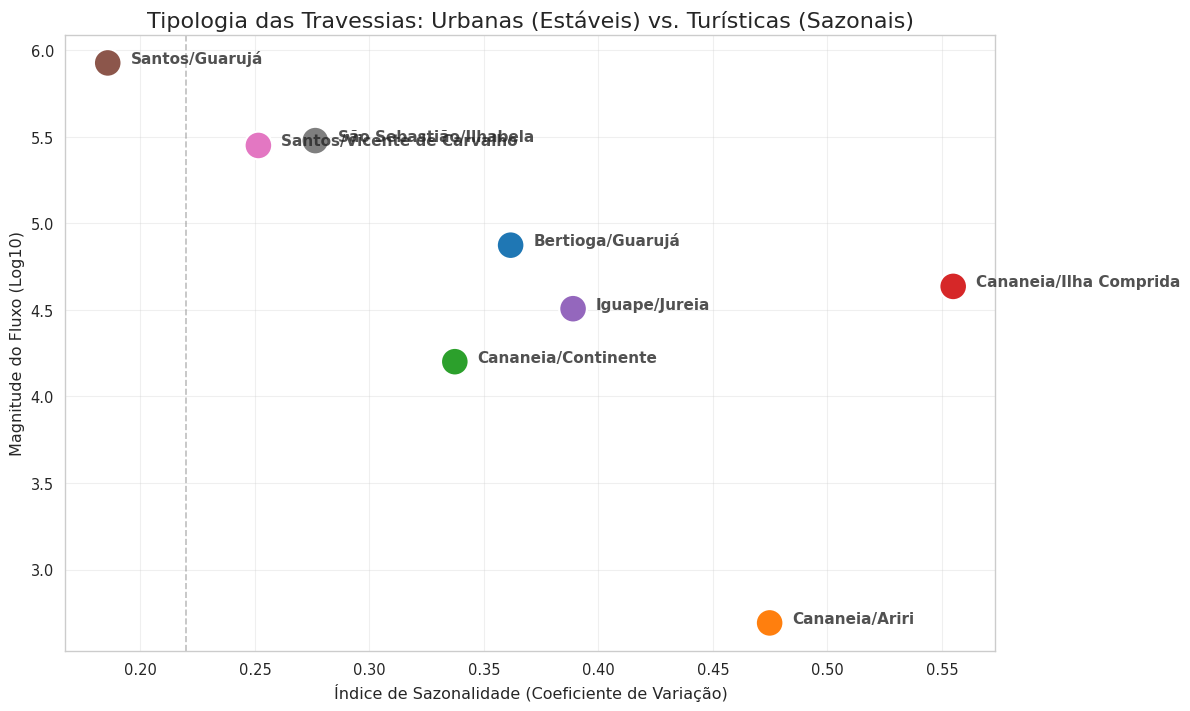

>>> Rodando Modelagem Comparativa em todas as travessias...


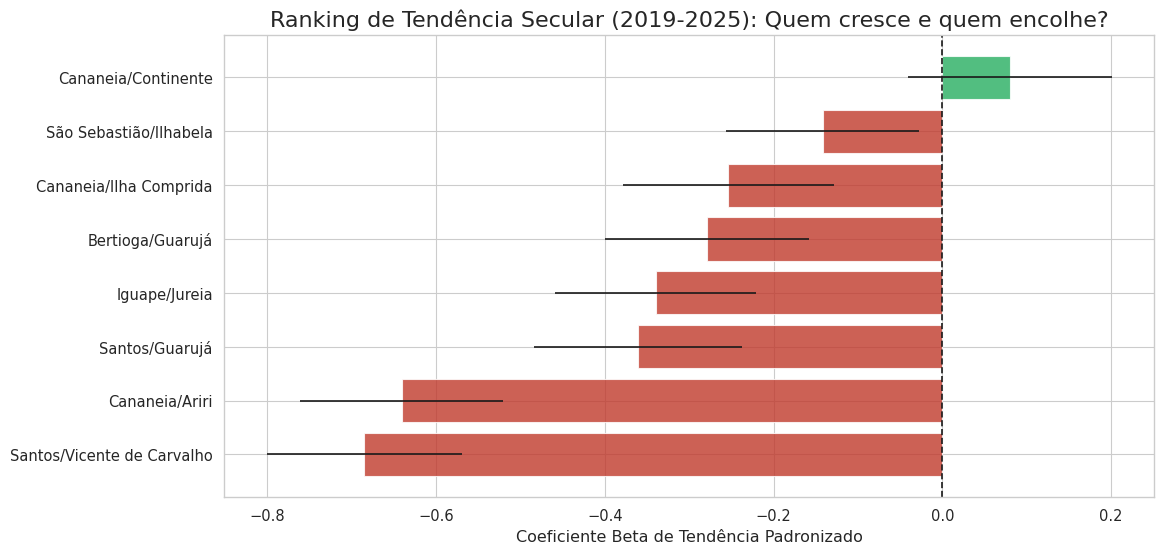

In [ ]:
print("\n>>> [2/5] Gerando Análise Sistêmica (Tipologia)...")

# Tipologia (Cluster: Volume x Sazonalidade)
metrics = df_raw.groupby('Travessia')['Volume Total'].agg(['mean', 'std'])
metrics['CV'] = metrics['std'] / metrics['mean'] # Coeficiente de Variação
metrics['Log_Vol'] = np.log10(metrics['mean'])

plt.figure(figsize=(12, 8))
sns.scatterplot(data=metrics, x='CV', y='Log_Vol', s=400, hue='Travessia', palette='tab10', legend=False)

for i in range(metrics.shape[0]):
    plt.text(metrics['CV'].iloc[i]+0.01, metrics['Log_Vol'].iloc[i],
             metrics.index[i], fontsize=11, weight='bold', alpha=0.8)

plt.title('Tipologia das Travessias: Urbanas (Estáveis) vs. Turísticas (Sazonais)', fontsize=16)
plt.xlabel('Índice de Sazonalidade (Coeficiente de Variação)')
plt.ylabel('Magnitude do Fluxo (Log10)')
plt.axvline(x=0.22, color='gray', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.show()

# Ranking de Tendências (Modelagem Bayesiana Comparativa)
print(">>> Rodando Modelagem Comparativa em todas as travessias...")
results_systemic = []

for travessia in df_raw['Travessia'].unique():
    df_t = df_raw[df_raw['Travessia'] == travessia].copy()
    if len(df_t) < 30: continue # Pula dados insuficientes

    # Prep Rápida
    df_t['t'] = np.arange(len(df_t))
    scaler_loc = StandardScaler()
    y_scaled_loc = scaler_loc.fit_transform(df_t[['Volume Total']]).flatten()
    is_pandemic = np.where((df_t['Data'] >= '2020-03-01') & (df_t['Data'] <= '2021-06-01'), 1, 0)
    t_norm = (df_t['t'] - df_t['t'].mean()) / df_t['t'].std()

    # Modelo Bayesiano Leve
    with pm.Model() as model_loc:
        beta_trend = pm.Normal('Trend', mu=0, sigma=1)
        beta_pan = pm.Normal('Pandemia', mu=-1, sigma=1)
        mu = pm.Normal('alpha', 0, 1) + beta_trend * t_norm + beta_pan * is_pandemic
        pm.Normal('y_obs', mu=mu, sigma=1, observed=y_scaled_loc)
        trace_loc = pm.sample(800, chains=2, progressbar=False)

    summ = az.summary(trace_loc, var_names=['Trend'])
    results_systemic.append({'Travessia': travessia, 'Trend': summ.loc['Trend', 'mean'], 'Erro': summ.loc['Trend', 'sd']})

df_sys = pd.DataFrame(results_systemic).sort_values('Trend', ascending=True)

# Plot Ranking
plt.figure(figsize=(12, 6))
colors = ['#c0392b' if x < 0 else '#27ae60' for x in df_sys['Trend']]
plt.barh(df_sys['Travessia'], df_sys['Trend'], xerr=df_sys['Erro'], color=colors, alpha=0.8)
plt.axvline(0, color='k', linestyle='--')
plt.title('Ranking de Tendência Secular (2019-2025): Quem cresce e quem encolhe?', fontsize=16)
plt.xlabel('Coeficiente Beta de Tendência Padronizado')
plt.show()

## 3. Modelagem e Teste de Hipóteses

O principal desafio deste dataset é a alta volatilidade (ruído) e o impacto massivo da pandemia em 2020/2021. Para tentar modelar o comportamento do fluxo, utilizamos duas abordagens:

1.  **Machine Learning (XGBoost):** Para identificar quais variáveis (Tempo, Economia, Pandemia) o algoritmo considera mais importantes para a previsão.
2.  **Estatística Bayesiana (PyMC):** Para tentar quantificar o impacto de cada variável e, principalmente, medir a incerteza da nossa análise.

A equação tenta explicar o fluxo ($Y$) baseada em uma tendência de tempo, na sazonalidade (seno/cosseno) e na variável econômica.


>>> [3/5] Aprofundando no Caso Santos-Guarujá...


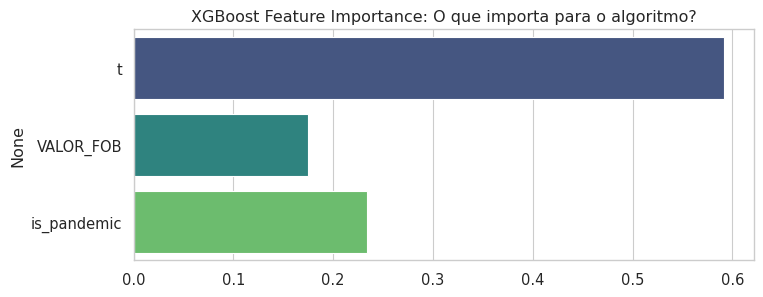

In [ ]:
print("\n>>> [3/5] Aprofundando no Caso Santos-Guarujá...")

# Merge Final para Santos
df_santos = df_raw[df_raw['Travessia'] == 'Santos/Guarujá'].copy()
df = pd.merge(df_santos, df_imp_agrupado[['Data', 'VALOR_FOB']], on='Data', how='inner')
df = df[df['VALOR_FOB'] < 2.5e9].copy() # Filtro outlier importação

# Feature Engineering
df['t'] = np.arange(len(df))
df['is_pandemic'] = np.where((df['Data'] >= '2020-03-01') & (df['Data'] <= '2021-06-01'), 1, 0)
df['sin_1'] = np.sin(2 * np.pi * 1 * df['t'] / 12)
df['cos_1'] = np.cos(2 * np.pi * 1 * df['t'] / 12)

# Benchmark Machine Learning (XGBoost)
X_ml = df[['t', 'VALOR_FOB', 'is_pandemic']]
y_ml = df['Volume Total']
gb = GradientBoostingRegressor(n_estimators=100).fit(X_ml, y_ml)

plt.figure(figsize=(8, 3))
sns.barplot(x=gb.feature_importances_, y=X_ml.columns, palette='viridis')
plt.title('XGBoost Feature Importance: O que importa para o algoritmo?')
plt.show()

## 4. Modelagem Estrutural Bayesiana (Inferência Causal)

Para quantificar a incerteza e isolar os efeitos, construímos um Modelo de Regressão Linear Bayesiana com Verossimilhança Robusta (*Student-t*), definida pela equação estrutural:

$$ \mu_t = \alpha + \beta_{trend} \cdot t + \beta_{econ} \cdot X_{imp} + \beta_{covid} \cdot D_{pan} + \beta_{saz} \cdot Fourier(t) $$

**Definições do Modelo:**
*   **Likelihood Student-t:** Escolhida para tolerar a alta curtose (caudas longas) observada nos dados de tráfego, tornando o modelo resiliente a outliers pontuais (ex: feriados atípicos).
*   **Priors:** Utilizadas distribuições Normais fracamente informativas ($\mathcal{N}(0, 1)$) para permitir que os dados ditem a posteriori.


>>> [4/5] Rodando Inferência Bayesiana Estrutural (Aguarde)...


Output()

<Figure size 1000x500 with 0 Axes>

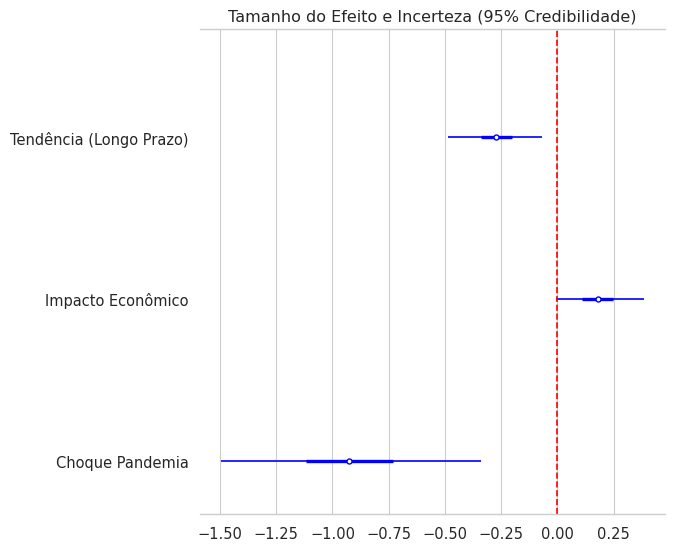

In [ ]:
print("\n>>> [4/5] Rodando Inferência Bayesiana Estrutural (Aguarde)...")

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(df[['Volume Total']]).flatten()
scaler_econ = StandardScaler()
econ_scaled = scaler_econ.fit_transform(df[['VALOR_FOB']]).flatten()
t_norm = (df['t'] - df['t'].mean()) / df['t'].std()

with pm.Model() as model_bayes:
    # Priors
    alpha = pm.Normal('alpha', 0, 1)
    sigma = pm.HalfNormal('sigma', 1)

    # Componentes
    beta_trend = pm.Normal('Tendência (Longo Prazo)', 0, 1)
    beta_econ = pm.Normal('Impacto Econômico', 0, 1)
    beta_pan = pm.Normal('Choque Pandemia', -1, 1)
    beta_saz = pm.Normal('Sazonalidade', 0, 1)

    # Equação
    mu = (alpha + beta_trend * t_norm + beta_econ * econ_scaled +
          beta_pan * df['is_pandemic'] + beta_saz * (df['sin_1'] + df['cos_1']))

    # Likelihood Robusta (Student-T)
    pm.StudentT('y_obs', mu=mu, sigma=sigma, nu=pm.Exponential('nu', 0.1), observed=y_scaled)

    # Sampling
    trace = pm.sample(2000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)

# Forest Plot
plt.figure(figsize=(10, 5))
az.plot_forest(trace, var_names=['Tendência (Longo Prazo)', 'Impacto Econômico', 'Choque Pandemia'],
               combined=True, hdi_prob=0.95, colors='blue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Tamanho do Efeito e Incerteza (95% Credibilidade)")
plt.show()


>>> [5/5] Gerando Diagnóstico Final...


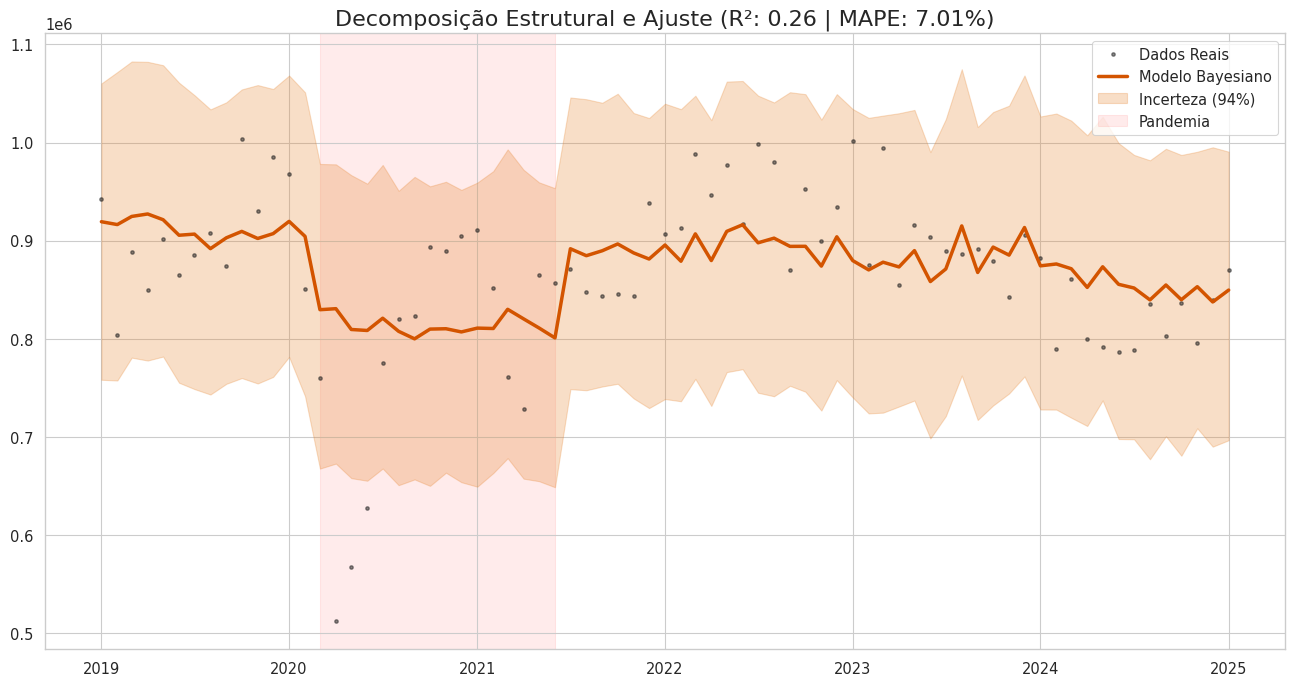


=== TABELA FINAL DE RESULTADOS ===
                          mean     sd  hdi_2.5%  hdi_97.5%
Tendência (Longo Prazo) -0.271  0.108    -0.488     -0.069
Impacto Econômico        0.180  0.100    -0.007      0.384
Choque Pandemia         -0.925  0.295    -1.494     -0.340


In [ ]:
print("\n>>> [5/5] Gerando Diagnóstico Final...")

with model_bayes:
    ppc = pm.sample_posterior_predictive(trace, extend_inferencedata=True, progressbar=False)

# recuperação da escala real
y_pred_scaled = ppc.posterior_predictive['y_obs'].mean(dim=["chain", "draw"])
y_pred = scaler_y.inverse_transform(y_pred_scaled.values.reshape(-1, 1)).flatten()

# intervalo de credibilidade
hdi = az.hdi(ppc.posterior_predictive, hdi_prob=0.94)['y_obs']
hdi_low = scaler_y.inverse_transform(hdi.sel(hdi="lower").values.reshape(-1, 1)).flatten()
hdi_high = scaler_y.inverse_transform(hdi.sel(hdi="higher").values.reshape(-1, 1)).flatten()

# métricas
mape = np.mean(np.abs((df['Volume Total'] - y_pred) / df['Volume Total'])) * 100
r2 = r2_score(df['Volume Total'], y_pred)
rmse = np.sqrt(mean_squared_error(df['Volume Total'], y_pred))

# plott
plt.figure(figsize=(16, 8))
plt.plot(df['Data'], df['Volume Total'], 'k.', alpha=0.5, label='Dados Reais', zorder=3)
plt.plot(df['Data'], y_pred, color='#d35400', linewidth=2.5, label='Modelo Bayesiano', zorder=4)
plt.fill_between(df['Data'], hdi_low, hdi_high, color='#e67e22', alpha=0.25, label='Incerteza (94%)', zorder=1)
plt.axvspan(pd.to_datetime('2020-03-01'), pd.to_datetime('2021-06-01'), color='red', alpha=0.08, label='Pandemia', zorder=0)

plt.title(f'Decomposição Estrutural e Ajuste (R²: {r2:.2f} | MAPE: {mape:.2f}%)', fontsize=16)
plt.legend(loc='upper right')
plt.show()

summary_final = az.summary(trace, var_names=['Tendência (Longo Prazo)', 'Impacto Econômico', 'Choque Pandemia'], hdi_prob=0.95)
print("\n=== TABELA FINAL DE RESULTADOS ===")
print(summary_final[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']])

## 4. Resultados e Conclusão

A análise dos dados apresentou resultados interessantes e desafiadores:

1.  **Impacto da Pandemia:** Como esperado, a pandemia foi o fator mais determinante na queda do fluxo, gerando uma ruptura clara nos gráficos.
2.  **Tendência de Queda:** O modelo Bayesiano indicou uma leve tendência negativa no longo prazo ($\beta \approx -0.27$), sugerindo que o fluxo não retornou completamente aos patamares de 2019, mesmo com a retomada econômica.
3.  **Relação com a Economia:** A hipótese inicial de que "Mais Importação = Mais Trânsito na Balsa" mostrou-se fraca. O modelo encontrou uma correlação positiva, mas muito pequena e incerta.

**Conclusão Final:**
Os dados sugerem que o fluxo da balsa Santos-Guarujá é complexo e saturado. Embora exista alguma relação com a economia, ela não é linear. Fatores operacionais (limite de capacidade das balsas) e a mudança de hábitos pós-pandemia parecem ter mais peso do que apenas o volume de importações do porto.